## Iterate like a grandmaster

**Note**: If you're fairly new to Kaggle, NLP, or Transformers, I strongly recommend you read my [Getting Started](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners) notebook first, and then come back to this one.

---

There's a lot of impressive notebooks around on Kaggle, but they often  fall into one of two categories:

- Exploratory Data Analysis (EDA) notebooks with lots of pretty charts, but not much focus on understanding the key issues that will make a difference in the competition
- Training/inference notebooks with little detail about *why* each step was chosen.

In this notebook I'll try to give a taste of how a competitions grandmaster might tackle the [U.S. Patent Phrase to Phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/) competition. The focus generally should be two things:

1. Creating an effective validation set
1. Iterating rapidly to find changes which improve results on the validation set.

If you can do these two things, then you can try out lots of experiments and find what works, and what doesn't. Without these two things, it will be nearly impossible to do well in a Kaggle competition (and, indeed, to create highly accurate models in real life!)

I will show a couple of different ways to create an appropriate validation set, and will explain how to expand them into an appropriate cross-validation system. I'll use just plain HuggingFace Transformers for everything, and will keep the code concise and simple. The more code you have, the more you have to maintain, and the more chances there are to make mistakes. So keep it simple!

OK, let's get started...

It's nice to be able to run things locally too, to save your Kaggle GPU hours, so set a variable to make it easy to see where we are, and download what we need:

In [2]:
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 260.9 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for python-slugify from https://files.pythonhosted.org/packages/a4/62/02da182e544a51a5c3ccf4b03ab79df279f9c60c5e82d5e8bec7ca26ac11/python_slugify-8.0.4-py2.py3-none-any.whl.metadata
  Obtaining dependency information for text-unidecode>=1.3 from https://files.pythonhosted.org/packages/a6/a5/c0b6468d3824fe3fde30dbb5e1f687b291608f9473681bbf7dabbf5a87d7/text_unidecode-1.3-py2.py3-none-any.whl.metadata
Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=62b750f3a92f21cde159eb09a93827f449ecef36b9e4719d14ddad0ac9e244b5
  Stored in directory: /Users/sdcarr/Library/Caches/pip/wheels/9f/af/22/bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle


In [1]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('us-patent-phrase-to-phrase-matching')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

us-patent-phrase-to-phrase-matching.zip: Skipping, found more recently modified local copy (use --force to force download)


A lot of the basic imports you'll want (`np`, `pd`, `plt`, etc) are provided by fastai, so let's grab them in one line:

In [2]:
from fastai.imports import *

## Import and EDA

Set a path to our data. Use `pathlib.Path` because it makes everything so much easier, and make it work automatically regardless if you're working on your own PC or on Kaggle!

In [5]:
if iskaggle: path = Path('us-patent-phrase-to-phrase-matching')
path.ls()

(#3) [Path('us-patent-phrase-to-phrase-matching/test.csv'),Path('us-patent-phrase-to-phrase-matching/train.csv'),Path('us-patent-phrase-to-phrase-matching/sample_submission.csv')]

In [6]:
!ls

iterate-like-a-grandmaster.ipynb        us-patent-phrase-to-phrase-matching.zip
notes.md                                utilidades
us-patent-phrase-to-phrase-matching


Let's look at the training set:

In [7]:
df = pd.read_csv(path/'train.csv')
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [16]:
df = pd.read_csv(path/'test.csv')
df

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04
5,474c874d0c07bd21,dry corn,dry corn starch,C12
6,442c114ed5c4e3c9,tunneling capacitor,capacitor housing,G11
7,b8ae62ea5e1d8bdb,angular contact bearing,contact therapy radiation,B23
8,faaddaf8fcba8a3f,produce liquid hydrocarbons,produce a treated stream,C10
9,ae0262c02566d2ce,diesel fuel tank,diesel fuel tanks,F02


...and the test set:

In [10]:
!ls {path}

sample_submission.csv test.csv              train.csv


In [17]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


# a partir de aquí sigo la explicación de Jeremy Howard en el video "Lesson 4"

In [24]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

In [25]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement
1            TEXT1: A47; TEXT2: act of abating; ANC1: abatement
2           TEXT1: A47; TEXT2: active catalyst; ANC1: abatement
3       TEXT1: A47; TEXT2: eliminating process; ANC1: abatement
4             TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

In [31]:
!pip install datasets

In [34]:
from datasets import Dataset, DatasetDict
ds = Dataset.from_pandas(df)

In [35]:
model_nm = 'microsoft/deberta-v3-small'

# AoutoTokenizer creará un tokenizador apropiado para un modelo dado

In [37]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [39]:
tokz.tokenize("G'day, I'm Silvino Díaz from fast.ai!")

['▁G',
 "'",
 'day',
 ',',
 '▁I',
 "'",
 'm',
 '▁Silvi',
 'no',
 '▁Díaz',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

In [40]:
tokz.tokenize("Hola Mundo, estoy aprendiendo con Jeremy fastai en 2024 verano!")

['▁Hola',
 '▁Mundo',
 ',',
 '▁esto',
 'y',
 '▁a',
 'prendi',
 'endo',
 '▁con',
 '▁Jeremy',
 '▁fast',
 'ai',
 '▁en',
 '▁2024',
 '▁vera',
 'no',
 '!']

In [12]:
eval_df = pd.read_csv(path/'test.csv')
len(eval_df)

36

In [17]:
eval_df.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


Let's look at the distribution of values of `target`:

In [21]:
df.target.value_counts()

target
composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: count, Length: 29340, dtype: int64

We see that there's nearly as many unique targets as items in the training set, so they're nearly but not quite unique. Most importantly, we can see that these generally contain very few words (1-4 words in the above sample).

Let's check `anchor`:

In [22]:
df.anchor.value_counts()

anchor
component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: count, Length: 733, dtype: int64

We can see here that there's far fewer unique values (just 733) and that again they're very short (2-4 words in this sample).

Now we'll do `context`

In [23]:
df.context.value_counts()

context
H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: count, Length: 106, dtype: int64

These are just short codes. Some of them have very few examples (18 in the smallest case) The first character is the section the patent was filed under -- let's create a column for that and look at the distribution:

Se trata sólo de códigos cortos. Algunos de ellos tienen muy pocos ejemplos (18 en el caso más pequeño) El primer carácter es la sección bajo la que se presentó la patente -- creemos una columna para eso y miremos la distribución:

In [24]:
df['section'] = df.context.str[0]
df.section.value_counts()

section
B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: count, dtype: int64

It seems likely that these sections might be useful, since they've got quite a bit more data in each.

Finally, we'll take a look at a histogram of the scores:

Parece probable que estas secciones sean útiles, ya que tienen bastantes más datos cada una.

Por último, echaremos un vistazo a un histograma de las puntuaciones:

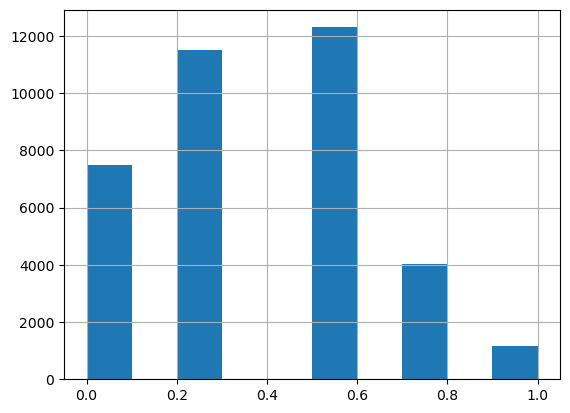

In [25]:
df.score.hist();

There's a small number that are scored `1.0` - here's a sample:

In [27]:
df[df.score==1]

,id,anchor,target,context,score,section
28,473137168ebf7484,abatement,abating,F24,1.0,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,B
...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,B


We can see from this that these are just minor rewordings of the same concept, and isn't likely to be specific to `context`. Any pretrained model should be pretty good at finding these already.

Podemos ver que se trata de pequeñas reformulaciones del mismo concepto y no es probable que sean específicas del contexto. Cualquier modelo preentrenado debería ser capaz de encontrarlas.

## Training

Time to import the stuff we'll need for training:

In [28]:
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

In [29]:
if iskaggle:
    !pip install -q datasets
import datasets
from datasets import load_dataset, Dataset, DatasetDict

HuggingFace Transformers tends to be rather enthusiastic about spitting out lots of warnings, so let's quieten it down for our sanity:

In [30]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

I tried to find a model that I could train reasonably at home in under two minutes, but got reasonable accuracy from. I found that deberta-v3-small fits the bill, so let's use it:

In [31]:
model_nm = 'microsoft/deberta-v3-small'

We can now create a tokenizer for this model. Note that pretrained models assume that text is tokenized in a particular way. In order to ensure that your tokenizer matches your model, use the `AutoTokenizer`, passing in your model name.

In [33]:
tokz = AutoTokenizer.from_pretrained(model_nm)

ImportError: 
DebertaV2Converter requires the protobuf library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/protocolbuffers/protobuf/tree/master/python#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


We'll need to combine the context, anchor, and target together somehow. There's not much research as to the best way to do this, so we may need to iterate a bit. To start with, we'll just combine them all into a single string. The model will need to know where each section starts, so we can use the special separator token to tell it:

In [18]:
sep = tokz.sep_token
sep

'[SEP]'

Let's now created our combined column:

In [19]:
df['inputs'] = df.context + sep + df.anchor + sep + df.target

Generally we'll get best performance if we convert pandas DataFrames into HuggingFace Datasets, so we'll convert them over, and also rename the score column to what Transformers expects for the dependent variable, which is `label`:

In [20]:
ds = Dataset.from_pandas(df).rename_column('score', 'label')
eval_ds = Dataset.from_pandas(eval_df)

To tokenize the data, we'll create a function (since that's what `Dataset.map` will need):

In [21]:
def tok_func(x): return tokz(x["inputs"])

Let's try tokenizing one input and see how it looks

In [22]:
tok_func(ds[0])

{'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

The only bit we care about at the moment is `input_ids`. We can see in the tokens that it starts with a special token `1` (which represents the start of text), and then has our three fields separated by the separator token `2`. We can check the indices of the special token IDs like so:

In [23]:
tokz.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

We can now tokenize the input. We'll use batching to speed it up, and remove the columns we no longer need:

In [24]:
inps = "anchor","target","context"
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id','section'))

  0%|          | 0/37 [00:00<?, ?ba/s]

Looking at the first item of the dataset we should see the same information as when we checked `tok_func` above:

In [25]:
tok_ds[0]

{'label': 0.5,
 'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Creating a validation set

According to [this post](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/discussion/315220), the private test anchors do not overlap with the training set. So let's do the same thing for our validation set.

First, create a randomly shuffled list of anchors:

In [26]:
anchors = df.anchor.unique()
np.random.seed(42)
np.random.shuffle(anchors)
anchors[:5]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation'], dtype=object)

Now we can pick some proportion (e.g 25%) of these anchors to go in the validation set:

In [27]:
val_prop = 0.25
val_sz = int(len(anchors)*val_prop)
val_anchors = anchors[:val_sz]

Now we can get a list of which rows match `val_anchors`, and get their indices:

In [28]:
is_val = np.isin(df.anchor, val_anchors)
idxs = np.arange(len(df))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
len(val_idxs),len(trn_idxs)

(9116, 27357)

Our training and validation `Dataset`s can now be selected, and put into a `DatasetDict` ready for training:

In [29]:
dds = DatasetDict({"train":tok_ds.select(trn_idxs),
             "test": tok_ds.select(val_idxs)})

BTW, a lot of people do more complex stuff for creating their validation set, but with a dataset this large there's not much point. As you can see, the mean scores in the two groups are very similar despite just doing a random shuffle:

In [30]:
df.iloc[trn_idxs].score.mean(),df.iloc[val_idxs].score.mean()

(0.3623021530138539, 0.3613426941641071)

## Initial model

Let's now train our model! We'll need to specify a metric, which is the correlation coefficient provided by numpy (we need to return a dictionary since that's how Transformers knows what label to use):

In [31]:
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}

We pick a learning rate and batch size that fits our GPU, and pick a reasonable weight decay and small number of epochs:

In [32]:
lr,bs = 8e-5,128
wd,epochs = 0.01,4

Three epochs might not sound like much, but you'll see once we train that most of the progress can be made in that time, so this is good for experimentation.

Transformers uses the `TrainingArguments` class to set up arguments. We'll use a cosine scheduler with warmup, since at fast.ai we've found that's pretty reliable. We'll use fp16 since it's much faster on modern GPUs, and saves some memory. We evaluate using double-sized batches, since no gradients are stored so we can do twice as many rows at a time.

In [33]:
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr)

In [34]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=wd, report_to='none')

We can now create our model, and `Trainer`, which is a class which combines the data and model together (just like `Learner` in fastai):

In [35]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
               tokenizer=tokz, compute_metrics=corr)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Let's train our model!

In [36]:
trainer.train();

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.025167,0.798359
2,No log,0.025149,0.803286
3,0.035300,0.024344,0.815202
4,0.035300,0.024549,0.815378


## Improving the model

We now want to start iterating to improve this. To do that, we need to know whether the model gives stable results. I tried training it 3 times from scratch, and got a range of outcomes from 0.808-0.810. This is stable enough to make a start - if we're not finding improvements that are visible within this range, then they're not very significant! Later on, if and when we feel confident that we've got the basics right, we can use cross validation and more epochs of training.

Iteration speed is critical, so we need to quickly be able to try different data processing and trainer parameters. So let's create a function to quickly apply tokenization and create our `DatasetDict`:

In [37]:
def get_dds(df):
    ds = Dataset.from_pandas(df).rename_column('score', 'label')
    tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id','section'))
    return DatasetDict({"train":tok_ds.select(trn_idxs), "test": tok_ds.select(val_idxs)})

...and also a function to create a `Trainer`:

In [38]:
def get_model(): return AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

def get_trainer(dds, model=None):
    if model is None: model = get_model()
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr)

Let's now try out some ideas...

Perhaps using the special separator character isn't a good idea, and we should use something we create instead. Let's see if that makes things better. First we'll change the separator and create the `DatasetDict`:

In [39]:
sep = " [s] "
df['inputs'] = df.context + sep + df.anchor + sep + df.target
dds = get_dds(df)

  0%|          | 0/37 [00:00<?, ?ba/s]

...and create and train a model. 

In [40]:
get_trainer(dds).train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024909,0.797869
2,No log,0.024800,0.812953
3,0.031600,0.024418,0.818292
4,0.031600,0.024037,0.819089


TrainOutput(global_step=856, training_loss=0.023822079752093165, metrics={'train_runtime': 269.6383, 'train_samples_per_second': 405.833, 'train_steps_per_second': 3.175, 'total_flos': 582160588599300.0, 'train_loss': 0.023822079752093165, 'epoch': 4.0})

That's looking quite a bit better, so we'll keep that change.

Often changing to lowercase is helpful. Let's see if that helps too:

In [41]:
df['inputs'] = df.inputs.str.lower()
dds = get_dds(df)
get_trainer(dds).train()

  0%|          | 0/37 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.025170,0.798002
2,No log,0.024433,0.815301
3,0.031500,0.024575,0.818443
4,0.031500,0.024150,0.818868


TrainOutput(global_step=856, training_loss=0.023811190484840178, metrics={'train_runtime': 274.7918, 'train_samples_per_second': 398.222, 'train_steps_per_second': 3.115, 'total_flos': 582160588599300.0, 'train_loss': 0.023811190484840178, 'epoch': 4.0})

That one is less clear. We'll keep that change too since most times I run it, it's a little better.

## Special tokens

What if we made the patent section a special token? Then potentially the model might learn to recognize that different sections need to be handled in different ways. To do that, we'll use, e.g. `[A]` for section A. We'll then add those as special tokens:

In [42]:
df['sectok'] = '[' + df.section + ']'
sectoks = list(df.sectok.unique())
tokz.add_special_tokens({'additional_special_tokens': sectoks})

8

We concatenate the section token to the start of our inputs:

In [43]:
df['inputs'] = df.sectok + sep + df.context + sep + df.anchor.str.lower() + sep + df.target
dds = get_dds(df)

  0%|          | 0/37 [00:00<?, ?ba/s]

Since we've added more tokens, we need to resize the embedding matrix in the model:

In [44]:
model = get_model()
model.resize_token_embeddings(len(tokz))

Embedding(128009, 768)

Now we're ready to train:

In [45]:
trainer = get_trainer(dds, model=model)
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024835,0.797996
2,No log,0.024412,0.812386
3,0.031800,0.024019,0.820914
4,0.031800,0.024220,0.820187


TrainOutput(global_step=856, training_loss=0.023861238889605084, metrics={'train_runtime': 296.1519, 'train_samples_per_second': 369.5, 'train_steps_per_second': 2.89, 'total_flos': 695409809982180.0, 'train_loss': 0.023861238889605084, 'epoch': 4.0})

It looks like we've made another bit of an improvement!

There's plenty more things you could try. Here's some thoughts:

- Try a model pretrained on legal vocabulary. E.g. how about [BERT for patents](https://huggingface.co/anferico/bert-for-patents)?
- You'd likely get better results by using a sentence similarity model. Did you know that there's a [patent similarity model](https://huggingface.co/AI-Growth-Lab/PatentSBERTa) you could try?
- You could also fine-tune any HuggingFace model using the full patent database (which is provided in BigQuery), before applying it to this dataset
- Replace the patent context field with the description of that context provided by the patent office
- ...and try out your own ideas too!

Before submitting a model, retrain it on the full dataset, rather than just the 75% training subset we've used here. Create a function like the ones above to make that easy for you!"

## Cross-validation

In [46]:
n_folds = 4

Once you've gotten the low hanging fruit, you might want to use cross-validation to see the impact of minor changes. This time we'll use [StratifiedGroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold), partly just to show a different approach to before, and partly because it will give us slightly better balanced datasets.

In [47]:
from sklearn.model_selection import StratifiedGroupKFold
cv = StratifiedGroupKFold(n_splits=n_folds)

Here's how to split the data frame into `n_folds` groups, with non-overlapping anchors and matched scores, after randomly shuffling the rows:

In [48]:
df = df.sample(frac=1, random_state=42)
scores = (df.score*100).astype(int)
folds = list(cv.split(idxs, scores, df.anchor))
folds

[(array([    0,     1,     2, ..., 36469, 36471, 36472]),
  array([    8,    13,    14, ..., 36453, 36464, 36470])),
 (array([    0,     1,     5, ..., 36470, 36471, 36472]),
  array([    2,     3,     4, ..., 36459, 36461, 36462])),
 (array([    1,     2,     3, ..., 36467, 36470, 36472]),
  array([    0,     7,    11, ..., 36468, 36469, 36471])),
 (array([    0,     2,     3, ..., 36469, 36470, 36471]),
  array([    1,     5,     9, ..., 36465, 36467, 36472]))]

We can now create a little function to split into training and validation sets based on a fold:

In [49]:
def get_fold(folds, fold_num):
    trn,val = folds[fold_num]
    return DatasetDict({"train":tok_ds.select(trn), "test": tok_ds.select(val)})

Let's try it out:

In [50]:
dds = get_fold(folds, 0)
dds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27346
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9127
    })
})

We can now pass this into `get_trainer` as we did before. If we have, say, 4 folds, then doing that for each fold will give us 4 models, and 4 sets of predictions and metrics. You could ensemble the 4 models to get a stronger model, and can also average the 4 metrics to get a more accurate assessment of your model. Here's how to get the final epoch metrics from a trainer:

In [51]:
metrics = [o['eval_pearson'] for o in trainer.state.log_history if 'eval_pearson' in o]
metrics[-1]

0.8201874392079798

I hope you've found this a helpful guide to improving your results in this competition - and on Kaggle more generally! If you like it, please remember to give it an upvote, and don't hesitate to add a comment if you have any questions or thoughts to add. And if the ideas here are helpful to you in creating your models, I'd really appreciate a link back to this notebook or a comment below to let me know what helped.

In [13]:
# Reemplaza 'archivo.csv' con la ruta de tu archivo CSV
ruta_del_archivo = 'us-patent-phrase-to-phrase-matching/test.csv'

# Cargar el archivo CSV en un DataFrame
df1 = pd.read_csv(ruta_del_archivo)

# Mostrar las primeras filas del DataFrame para verificar que se ha cargado correctamente
print(df.head())

                 id     anchor                  target context  score
0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50
1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75
2  36d72442aefd8232  abatement         active catalyst     A47   0.25
3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50
4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00


In [15]:
pd.open(ruta_del_archivo)

AttributeError: module 'pandas' has no attribute 'open'

In [16]:
print(df1)

                  id                       anchor  \
0   4112d61851461f60                     opc drum   
1   09e418c93a776564              adjust gas flow   
2   36baf228038e314b               lower trunnion   
3   1f37ead645e7f0c8                cap component   
4   71a5b6ad068d531f           neural stimulation   
5   474c874d0c07bd21                     dry corn   
6   442c114ed5c4e3c9          tunneling capacitor   
7   b8ae62ea5e1d8bdb      angular contact bearing   
8   faaddaf8fcba8a3f  produce liquid hydrocarbons   
9   ae0262c02566d2ce             diesel fuel tank   
10  a8808e31641e856d            chemical activity   
11  16ae4b99d3601e60         transmit to platform   
12  25c555ca3d5a2092                  oil tankers   
13  5203a36c501f1b7c            generate in layer   
14  b9fdc772bb8fd61c                 slip segment   
15  7aa5908a77a7ec24                   el display   
16  d19ef3979396d47e              overflow device   
17  fd83613b7843f5e1     beam traveling direct